In [1]:
### Load in necessary libraries for data input and normalization
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from my_answers import *

%load_ext autoreload
%autoreload 2

from my_answers import *

Using TensorFlow backend.
/home/morgan/miniconda3/envs/crypto/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [3]:
dataset_raw = pd.read_csv('datasets/coindesk-bpi-USD-close_data-2010-07-17_2017-12-24.csv')

In [4]:
dataset_raw['Close Price']

0           0.09
1           0.08
2           0.07
3           0.08
4           0.05
5           0.06
6           0.05
7           0.05
8           0.06
9           0.06
10          0.06
11          0.07
12          0.06
13          0.07
14          0.06
15          0.06
16          0.06
17          0.06
18          0.06
19          0.06
20          0.06
21          0.06
22          0.07
23          0.07
24          0.07
25          0.07
26          0.06
27          0.07
28          0.07
29          0.07
          ...   
2689     9739.05
2690     9908.23
2691     9816.35
2692     9916.54
2693    10859.56
2694    10895.01
2695    11180.89
2696    11616.85
2697    11696.06
2698    13708.99
2699    16858.02
2700    16057.14
2701    14913.40
2702    15036.96
2703    16699.68
2704    17178.10
2705    16407.20
2706    16531.08
2707    17601.94
2708    19343.04
2709    19086.64
2710    18960.52
2711    17608.35
2712    16454.72
2713    15561.05
2714    13857.14
2715    14548.71
2716    13817.

In [5]:
arr = np.array(dataset_raw['Close Price'])
arr

array([  9.00000000e-02,   8.00000000e-02,   7.00000000e-02, ...,
         1.38174000e+04,              nan,              nan])

In [6]:
arr = arr[~np.isnan(arr)]
arr

array([  9.00000000e-02,   8.00000000e-02,   7.00000000e-02, ...,
         1.38571400e+04,   1.45487100e+04,   1.38174000e+04])

In [14]:
#Get last 1500 prices
short_arr = arr[-1500:]
short_arr

array([   428.82,    476.29,    674.38, ...,  13857.14,  14548.71,  13817.4 ])

In [15]:
#Here we normalize the series to lie in the range [0,1] using this scikit function, but it is also commonplace to normalize by a series standard deviation.
#Reshape for scaler
reshaped_arr = short_arr.reshape(-1,1)

#scale
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_minmax = scaler.fit_transform(reshaped_arr)

#convert to array
dataset = X_train_minmax.flatten()

In [16]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


Lets take a quick look at the (normalized) time series we'll be performing predictions on.

Text(0,0.5,'normalized series value')

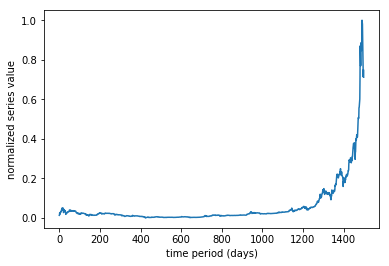

In [17]:
# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period (days)')
plt.ylabel('normalized series value')

## 1.2  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="images/timeseries_windowing_training.gif" width=600 height=600/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

You can test your function on the list of odd numbers given below

Again - you can check that your completed **window_transform_series** function works correctly by trying it on the odd_nums sequence - you should get the above output.

With this function in place apply it to the series in the Python cell below.  We use a window_size = 7 for these experiments.

In [18]:
# window the data using your windowing function
window_size = 7
X,y = window_transform_series(series = dataset,window_size = window_size)
print(X)
print(y)

[[ 0.01312445  0.01560126  0.02593688 ...,  0.02063002  0.02705815
   0.02975097]
 [ 0.01560126  0.02593688  0.0190209  ...,  0.02705815  0.02975097
   0.03127557]
 [ 0.02593688  0.0190209   0.02063002 ...,  0.02975097  0.03127557
   0.02995446]
 ..., 
 [ 0.9091557   1.          0.98662198 ...,  0.90949015  0.84929791
   0.80266945]
 [ 1.          0.98662198  0.98004149 ...,  0.84929791  0.80266945
   0.71376559]
 [ 0.98662198  0.98004149  0.90949015 ...,  0.80266945  0.71376559
   0.74984921]]
[[ 0.03127557]
 [ 0.02995446]
 [ 0.03137888]
 ..., 
 [ 0.71376559]
 [ 0.74984921]
 [ 0.7116921 ]]


## 1.3  Splitting into training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  This is that once we train our model we have something to test it on (like any regression problem!).  This splitting into training/testing sets is done in the cell below.

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [19]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

<a id='TODO_2'></a>

## 1.4  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LTSM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

(given in the cell below).  (remember to copy your completed function into the script *my_answers.py* function titled *build_part1_RNN* before submitting your project)

In [20]:
### TODO: create required RNN model
# import keras network libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

# given - fix random seed - so we can all reproduce the same results on our default time series
np.random.seed(0)


# TODO: implement build_part1_RNN in my_answers.py
# from my_answers import build_part1_RNN

model = Sequential()
model.add(LSTM(5, input_shape=(window_size, 1)))
model.add(Dense(1, activation='tanh'))
    
# build model using keras documentation recommended optimizer initialization
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

With your model built you can now fit the model by activating the cell below!  Note: the number of epochs (np_epochs) and batch_size are preset (so we can all produce the same results).  You can choose to toggle the verbose parameter - which gives you regular updates on the progress of the algorithm - on and off by setting it to 1 or 0 respectively.

In [21]:
# run your model!
model.fit(X_train, y_train, epochs=1000, batch_size=50, verbose=2)
model.save_weights('model_weights/RNN_prediction_weights_BTC_24Hour.hdf5')

Epoch 1/1000
 - 1s - loss: 3.2909e-05
Epoch 2/1000
 - 0s - loss: 2.3295e-05
Epoch 3/1000
 - 0s - loss: 1.6924e-05
Epoch 4/1000
 - 0s - loss: 1.3866e-05
Epoch 5/1000
 - 0s - loss: 9.7443e-06
Epoch 6/1000
 - 0s - loss: 7.9672e-06
Epoch 7/1000
 - 0s - loss: 6.7080e-06
Epoch 8/1000
 - 0s - loss: 8.7000e-06
Epoch 9/1000
 - 0s - loss: 7.3724e-06
Epoch 10/1000
 - 0s - loss: 6.7332e-06
Epoch 11/1000
 - 0s - loss: 5.7506e-06
Epoch 12/1000
 - 0s - loss: 6.8907e-06
Epoch 13/1000
 - 0s - loss: 6.7231e-06
Epoch 14/1000
 - 0s - loss: 6.6503e-06
Epoch 15/1000
 - 0s - loss: 7.0437e-06
Epoch 16/1000
 - 0s - loss: 6.0136e-06
Epoch 17/1000
 - 0s - loss: 5.6937e-06
Epoch 18/1000
 - 0s - loss: 7.2539e-06
Epoch 19/1000
 - 0s - loss: 6.6928e-06
Epoch 20/1000
 - 0s - loss: 6.3984e-06
Epoch 21/1000
 - 0s - loss: 6.7734e-06
Epoch 22/1000
 - 0s - loss: 5.9905e-06
Epoch 23/1000
 - 0s - loss: 6.2454e-06
Epoch 24/1000
 - 0s - loss: 5.0885e-06
Epoch 25/1000
 - 0s - loss: 6.3449e-06
Epoch 26/1000
 - 0s - loss: 6.5342

Epoch 209/1000
 - 0s - loss: 2.9650e-06
Epoch 210/1000
 - 0s - loss: 2.9340e-06
Epoch 211/1000
 - 0s - loss: 2.9048e-06
Epoch 212/1000
 - 0s - loss: 3.0916e-06
Epoch 213/1000
 - 0s - loss: 3.0348e-06
Epoch 214/1000
 - 0s - loss: 2.6424e-06
Epoch 215/1000
 - 0s - loss: 2.9342e-06
Epoch 216/1000
 - 0s - loss: 3.0858e-06
Epoch 217/1000
 - 0s - loss: 3.1189e-06
Epoch 218/1000
 - 0s - loss: 2.8485e-06
Epoch 219/1000
 - 0s - loss: 2.6190e-06
Epoch 220/1000
 - 0s - loss: 3.4229e-06
Epoch 221/1000
 - 0s - loss: 2.8259e-06
Epoch 222/1000
 - 0s - loss: 3.0795e-06
Epoch 223/1000
 - 0s - loss: 2.8411e-06
Epoch 224/1000
 - 0s - loss: 2.9362e-06
Epoch 225/1000
 - 0s - loss: 3.1802e-06
Epoch 226/1000
 - 0s - loss: 2.4155e-06
Epoch 227/1000
 - 0s - loss: 3.3157e-06
Epoch 228/1000
 - 0s - loss: 3.0912e-06
Epoch 229/1000
 - 0s - loss: 2.6328e-06
Epoch 230/1000
 - 0s - loss: 2.6661e-06
Epoch 231/1000
 - 0s - loss: 3.2668e-06
Epoch 232/1000
 - 0s - loss: 2.5247e-06
Epoch 233/1000
 - 0s - loss: 2.9657e-06


Epoch 414/1000
 - 0s - loss: 2.3949e-06
Epoch 415/1000
 - 0s - loss: 2.4633e-06
Epoch 416/1000
 - 0s - loss: 2.4816e-06
Epoch 417/1000
 - 0s - loss: 2.6335e-06
Epoch 418/1000
 - 0s - loss: 2.2881e-06
Epoch 419/1000
 - 0s - loss: 2.6870e-06
Epoch 420/1000
 - 0s - loss: 2.5667e-06
Epoch 421/1000
 - 0s - loss: 2.3053e-06
Epoch 422/1000
 - 0s - loss: 2.5185e-06
Epoch 423/1000
 - 0s - loss: 2.7606e-06
Epoch 424/1000
 - 0s - loss: 2.3773e-06
Epoch 425/1000
 - 0s - loss: 2.6366e-06
Epoch 426/1000
 - 0s - loss: 2.5735e-06
Epoch 427/1000
 - 0s - loss: 2.3514e-06
Epoch 428/1000
 - 0s - loss: 2.7473e-06
Epoch 429/1000
 - 0s - loss: 2.4597e-06
Epoch 430/1000
 - 0s - loss: 2.1959e-06
Epoch 431/1000
 - 0s - loss: 2.6312e-06
Epoch 432/1000
 - 0s - loss: 2.9325e-06
Epoch 433/1000
 - 0s - loss: 2.3600e-06
Epoch 434/1000
 - 0s - loss: 2.3627e-06
Epoch 435/1000
 - 0s - loss: 2.4857e-06
Epoch 436/1000
 - 0s - loss: 2.3845e-06
Epoch 437/1000
 - 0s - loss: 2.9342e-06
Epoch 438/1000
 - 0s - loss: 2.3144e-06


Epoch 619/1000
 - 0s - loss: 2.1665e-06
Epoch 620/1000
 - 0s - loss: 2.1453e-06
Epoch 621/1000
 - 0s - loss: 2.1558e-06
Epoch 622/1000
 - 0s - loss: 2.4768e-06
Epoch 623/1000
 - 0s - loss: 2.1674e-06
Epoch 624/1000
 - 0s - loss: 2.1532e-06
Epoch 625/1000
 - 0s - loss: 2.4211e-06
Epoch 626/1000
 - 0s - loss: 2.4356e-06
Epoch 627/1000
 - 0s - loss: 2.1437e-06
Epoch 628/1000
 - 0s - loss: 2.1648e-06
Epoch 629/1000
 - 0s - loss: 2.3533e-06
Epoch 630/1000
 - 0s - loss: 2.4356e-06
Epoch 631/1000
 - 0s - loss: 2.1412e-06
Epoch 632/1000
 - 0s - loss: 2.1532e-06
Epoch 633/1000
 - 0s - loss: 2.4982e-06
Epoch 634/1000
 - 0s - loss: 2.3397e-06
Epoch 635/1000
 - 0s - loss: 2.0662e-06
Epoch 636/1000
 - 0s - loss: 2.3154e-06
Epoch 637/1000
 - 0s - loss: 2.3777e-06
Epoch 638/1000
 - 0s - loss: 2.2468e-06
Epoch 639/1000
 - 0s - loss: 2.0796e-06
Epoch 640/1000
 - 0s - loss: 2.2655e-06
Epoch 641/1000
 - 0s - loss: 2.3193e-06
Epoch 642/1000
 - 0s - loss: 2.0648e-06
Epoch 643/1000
 - 0s - loss: 2.4804e-06


Epoch 824/1000
 - 0s - loss: 2.4201e-06
Epoch 825/1000
 - 0s - loss: 1.9290e-06
Epoch 826/1000
 - 0s - loss: 2.1885e-06
Epoch 827/1000
 - 0s - loss: 2.3156e-06
Epoch 828/1000
 - 0s - loss: 2.2808e-06
Epoch 829/1000
 - 0s - loss: 2.0349e-06
Epoch 830/1000
 - 0s - loss: 2.2346e-06
Epoch 831/1000
 - 0s - loss: 2.2163e-06
Epoch 832/1000
 - 0s - loss: 2.3858e-06
Epoch 833/1000
 - 0s - loss: 2.1210e-06
Epoch 834/1000
 - 0s - loss: 2.2124e-06
Epoch 835/1000
 - 0s - loss: 2.2320e-06
Epoch 836/1000
 - 0s - loss: 2.1940e-06
Epoch 837/1000
 - 0s - loss: 2.2939e-06
Epoch 838/1000
 - 0s - loss: 2.3044e-06
Epoch 839/1000
 - 0s - loss: 1.9469e-06
Epoch 840/1000
 - 0s - loss: 2.3012e-06
Epoch 841/1000
 - 0s - loss: 2.4061e-06
Epoch 842/1000
 - 0s - loss: 1.9683e-06
Epoch 843/1000
 - 0s - loss: 2.1768e-06
Epoch 844/1000
 - 0s - loss: 2.1294e-06
Epoch 845/1000
 - 0s - loss: 2.2978e-06
Epoch 846/1000
 - 0s - loss: 2.2087e-06
Epoch 847/1000
 - 0s - loss: 2.2042e-06
Epoch 848/1000
 - 0s - loss: 2.0543e-06


## Checking model performance

In [22]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [23]:
X_train[len(X_train) - 1]

array([[ 0.02167929],
       [ 0.02156659],
       [ 0.02126083],
       [ 0.02168503],
       [ 0.02135266],
       [ 0.0213271 ],
       [ 0.02127753]])

In [24]:
y_train[len(y_train) - 1]

array([ 0.02056584])

In [25]:
train_predict[len(train_predict) - 1]

array([ 0.02176701], dtype=float32)

In [26]:
test_predict[len(test_predict) - 1]

array([ 0.45904729], dtype=float32)

In [39]:
# Yesterdays Price
yest_day = scaler.inverse_transform(test_predict[len(test_predict) - 3][0])

In [40]:
# Todays Price
today_price = scaler.inverse_transform(test_predict[len(test_predict) - 2][0])

In [41]:
# Tomorrows Price
tom_price = scaler.inverse_transform(test_predict[len(test_predict) - 1][0])

In [53]:
def percentage_change(p1, p2):
    return ((p1-p2)/p1)[0][0]

print("Price change from Yesterday to Day: {:0f}%".format(percentage_change(today_price, yest_day) * 100))
print("Price change from Today to Tomorrow: {:0f}%".format(percentage_change(tom_price, today_price) * 100))


Price change from Yesterday to Day: -10.263810%
Price change from Today to Tomorrow: 8.975770%


In [30]:
train_predict

array([[ 0.02979775],
       [ 0.03133732],
       [ 0.03008354],
       [ 0.03174914],
       [ 0.03782083],
       [ 0.03988213],
       [ 0.04453557],
       [ 0.04857247],
       [ 0.04863035],
       [ 0.0396496 ],
       [ 0.04531272],
       [ 0.04599262],
       [ 0.04997146],
       [ 0.04416567],
       [ 0.0342698 ],
       [ 0.02795524],
       [ 0.03314179],
       [ 0.03750898],
       [ 0.0418772 ],
       [ 0.0362635 ],
       [ 0.03673101],
       [ 0.03779851],
       [ 0.03601404],
       [ 0.03674463],
       [ 0.02803868],
       [ 0.02728285],
       [ 0.01874009],
       [ 0.02809271],
       [ 0.02323778],
       [ 0.02301582],
       [ 0.0234793 ],
       [ 0.02627682],
       [ 0.02584418],
       [ 0.0269461 ],
       [ 0.03093993],
       [ 0.02977885],
       [ 0.02917944],
       [ 0.02999269],
       [ 0.03041263],
       [ 0.03052139],
       [ 0.03118154],
       [ 0.03309239],
       [ 0.0341162 ],
       [ 0.03560713],
       [ 0.03974685],
       [ 0

In the next cell we compute training and testing errors using our trained model - you should be able to achieve at least

*training_error* < 0.02

and 

*testing_error* < 0.02

with your fully trained model.  

If either or both of your accuracies are larger than 0.02 re-train your model - increasing the number of epochs you take (a maximum of around 1,000 should do the job) and/or adjusting your batch_size.

In [31]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=1)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=1)
print('testing error = ' + str(testing_error))

996/996 [==============================] - 0s 147us/step
training error = 1.75393089823e-06
497/497 [==============================] - 0s 99us/step
testing error = 0.00667166683198


Activating the next cell plots the original data, as well as both predictions on the training and testing sets. 

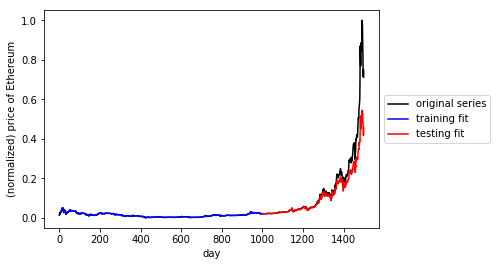

In [32]:
### Plot everything - the original series as well as predictions on training and testing sets

import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(dataset, color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Ethereum')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**Note:** you can try out any time series for this exercise!  If you would like to try another see e.g., [this site containing thousands of time series](https://datamarket.com/data/list/?q=provider%3Atsdl) and pick another one!

In [ ]:

scaler.transform()